In [2]:
import numpy as np
from numpy import linalg as LA
from scipy.interpolate import interp1d

In [3]:
import matplotlib.pyplot  as plt
import plotly.graph_objects as go
from time import time

In [4]:
def Init_stringA(A,B,N=20):
    
    temp=np.array([A,B])
    d1=temp[:,0]
    d2=temp[:,1]
    alpha=np.array([0,1])
    d1_re=Init_interpolation(alpha,d1,N).reshape(-1,1)
    d2_re=Init_interpolation(alpha,d2,N).reshape(-1,1)

    return np.concatenate([d1_re,d2_re],axis=1)
def Init_interpolation(x,y,N=20):
    f=interp1d(x, y, kind='linear')
    return f(np.array(range(N+1))/N)

In [251]:
def V(x):
    #V(x,y)=(x^2-1)^2+y^2
    Y=x[-1]
    X=x[0]
    return 1+np.sin(X)*np.sin(X)+np.sin(Y)*np.sin(Y)-np.exp(-(X*X+Y*Y))
#     return (X*X-1)*(X*X-1)+Y*Y

def gradient_V(x):
    '''gradient of V'''
    y=x[-1]
    x=x[0]
#     d1=4*X*X*X-4*X
#     d2=2*Y
    d1=2*np.sin(x)*np.cos(x)+2*x*np.exp(-(x*x+y*y))
    d2=2*np.sin(y)*np.cos(y)+2*y*np.exp(-(x*x+y*y))
    return np.array([d1,d2])

In [240]:
def V(x):
    #V(x,y)=(1-x^2-y^2)^2+y^2/(x^2+y^2)
    Y=x[-1]
    X=x[0]
    return (1-X*X-Y*Y)*(1-X*X-Y*Y)+Y*Y/(X*X+Y*Y)
def gradient_V(x):
    '''gradient of V'''
    Y=x[-1]
    X=x[0]
    d1=-4*X*(1-X*X-Y*Y)-Y*Y*2*X/((X*X+Y*Y)*(X*X+Y*Y))
    d2=-4*Y*(1-X*X-Y*Y)+Y*2*X*X/((X*X+Y*Y)*(X*X+Y*Y))
    return np.array([d1,d2])

In [250]:
[X,Y]=np.meshgrid(np.linspace(-2.5,2.5,200),np.linspace(-2.5,2.5,200))
Z=1+np.sin(X)*np.sin(X)+np.sin(Y)*np.sin(Y)-np.exp(-(X*X+Y*Y));


# [X,Y]=np.meshgrid(np.linspace(-1.3,1.3,200),np.linspace(-0.3,1.3,200))
# Z=(1-X*X-Y*Y)*(1-X*X-Y*Y)+Y*Y/(X*X+Y*Y)

In [220]:
def rungeKutta(phi,dt,f):
    '''
    solve autonomous ODE phi_t=f(phi),eq(6) in the paper with forth order
    phi: ith image of string, to update from nth iteration to (n+1)th iteration
    dt: time step
    f: a function
    '''
    k1=dt*f(phi)
    k2=dt*f(phi+1/2*k1)
    k3=dt*f(phi+1/2*k2)
    k4=dt*f(phi+k3)
    rg=-(k1/6+k2/3+k3/3+k4/6)#f=gradient V, there should minus
    return rg

def euler(phi,dt,gradient):
    '''
    explicit euler, gradient is \Delta V(phi)
    '''
    return -dt*gradient

In [221]:
def Repara(Phi,N=20):
    '''Phi is the string discretized by N images, each image is M-dimension'''
    length=len(Phi)
    #alpha^star
    s=[]
    s.append(0)#s_0=0
    for i in range(length-1):
#         s.append(s[i]+LA.norm(Phi[i+1,:]-Phi[i,:]))
        s.append(s[i]+np.exp(0.5*V(Phi[i+1,:])+0.5*V(Phi[i,:]))*LA.norm(Phi[i+1,:]-Phi[i,:]))
    alpha=np.array(s)/s[-1]
    #cubic spline interpolation for every dimension eg: (alpha,phi_1) and (alpha,phi_2)(if phi is two dimensional
    d_list=[]
    for i in range(Phi.shape[-1]):
        d=Phi[:,i]
        d_list.append(spline_repara(alpha,d,N).reshape(-1,1))#cubic spline interpolatation on every dimension

    return np.concatenate(d_list,axis=1)


In [222]:
def spline_repara(x,y,N=20):
    '''spline interpolation 1d
    divede into N images'''
    
    # from scipy.interpolate import splev, splrep
    # spl = splrep(x, y)
    # return splev(np.array(range(N+1))/N, spl)

    from scipy.interpolate import interp1d
    length=len(x)
#     if length<2:
#         print('Phi is empty or only has one point')
#     if length>3:#at least four points to cubic interpolation
#         f=interp1d(x, y, kind='cubic')
#     if length==3:#three points, quadratic interpolation
#         print('quadratic interpolation')
#         f=interp1d(x, y, kind='quadratic')
#     if length==2:#two points, linear interpolation
#         print('linear interpolation')
#         f=interp1d(x, y, kind='linear')
    f=interp1d(x, y, kind='cubic')
    return f(np.array(range(N+1))/N)

In [223]:
def Trunc(Phi):
    '''
    truncate the sequance to ganrantee energy monotonically increasing

    if Phi is monotonically increasing,skip this step
    oterhwise~
    '''
    a=list(map(V,Phi))
    flag=all([a[i] < a[i+1] for i in range(len(a)-1)])
    if flag:
        # print(flag)
        return Phi
    #if not  monotonically increasing, truncte the sequence  
    else:
        Phi_trunc=[]
        print('------beging truncate the images-------')
        # Phi_trunc.append(Phi[0,:])
        for i in range(len(Phi)-1):
            if not(V(Phi[i+1,:])<V(Phi[i,:])):
                # print(i)
                #V is the potential function
                Phi_trunc.append(Phi[i,:])
            else:
                break
        return np.array(Phi_trunc)

In [87]:
def Proj_gradient_V(phi,tao):
    gradient=gradient_V(phi)
    return gradient-np.matmul(tao,gradient)*tao
def SD_Proj_gradient_V(phi,tao):
    gradient=gradient_V(phi)
    return gradient-2*np.matmul(tao,gradient)*tao


In [255]:
a=np.array([0.0,0.0])
b=np.array([np.pi/2+0.5,0.1])
b=np.array([0.5,0.1])
# # init string need not be local minima
# a=np.array([-1,0])
# b=np.array([-0.55,.5])


In [256]:
N=10
TOL=max(pow(N,-4),pow(10,-10))
dt=0.05*min(0.2,1/N)

In [257]:
Init_string=Init_stringA(a,b,N)

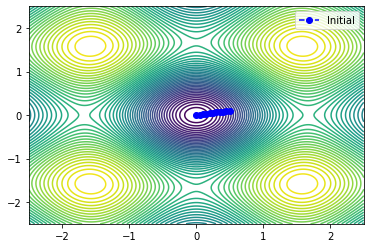

In [258]:
# plt.plot(Phi[:,0],Phi[:,1],'--ro')
plt.contour(X,Y,Z,50)
plt.plot(Init_string[:,0],Init_string[:,1],'b--o')
plt.legend(['Initial'])

In [117]:
map()

array([1.51511398, 0.2615798 ])

In [198]:
# def String_Error(Phi):
#     return max()

In [199]:
def String_Error(Phi,Phi_new):
    return [LA.norm(each)/dt for each in Phi-Phi_new]

Iteration 0
7.513882284655611


Iteration 1
1.5902444280768144


Iteration 2
1.6078023699080979


Iteration 3
1.623487264706746


Iteration 4
1.6388175475898985


Iteration 5
1.653770916644918


Iteration 6
1.6683265579490143


Iteration 7
1.6824634941999872


Iteration 8
1.6961603878318667


Iteration 9
1.7093953807671272


Iteration 10
1.7221460391743357


Iteration 11
1.7343894640418196


Iteration 12
1.7461025988337737


Iteration 13
1.7572627133971592


Iteration 14
1.76784798423066


Iteration 15
1.7778380570150445


Iteration 16
1.7872145095404253


Iteration 17
1.7959612637486437


Iteration 18
1.8040652146772733


Iteration 19
1.81151756498751


Iteration 20
1.818316396730168


Iteration 21
1.8244706377336477


Iteration 22
1.8300046008888997


Iteration 23
1.8349607456681054


Iteration 24
1.8393967460632488


Iteration 25
1.843372429733402


Iteration 26
1.846924139290511


Iteration 27
1.8500297336963825


Iteration 28
1.852576559687781


Iteration 29
1.854354384112335


It

0.42718366582213424


Iteration 266
0.2693417126379821


Iteration 267
0.29966927992003517


Iteration 268
0.3180568794269778


Iteration 269
0.3290315562137952


Iteration 270
0.3300193087652212


Iteration 271
0.3723531242423165


Iteration 272
------beging truncate the images-------
9.846618356003214


Iteration 273
0.5573760193282544


Iteration 274
0.46138493750241


Iteration 275
0.433499959255595


Iteration 276
0.4124955623860488


Iteration 277
------beging truncate the images-------
6.983834136592298


Iteration 278
0.16107420045251353


Iteration 279
0.12208514851789384


Iteration 280
0.11564964787266119


Iteration 281
0.11041710302529123


Iteration 282
0.10676888932623237


Iteration 283
0.10543238146194082


Iteration 284
0.10707300842237102


Iteration 285
0.11226287223101436


Iteration 286
0.12142599637424334


Iteration 287
0.1347384162450404


Iteration 288
0.15197157420180948


Iteration 289
0.1723051748073533


Iteration 290
0.19417342505992372


Iteration 291
0.

Iteration 501
0.008675758281696632


Iteration 502
0.008487703494125903


Iteration 503
0.008011196560819818


Iteration 504
0.00719856781394231


Iteration 505
0.006731680353908301


Iteration 506
0.007492648533106413


Iteration 507
0.008222000004216478


Iteration 508
0.009248850288433575


Iteration 509
0.010653680024676817


Iteration 510
0.012494046410700536


Iteration 511
0.014602559263365058


Iteration 512
0.016206934341038485


Iteration 513
0.018224320819019098


Iteration 514
------beging truncate the images-------
0.19490498069215173


Iteration 515
0.006139417337757521


Iteration 516
0.0019348001024071366


Iteration 517
0.0023485362032830163


Iteration 518
------beging truncate the images-------
0.06132680334274922


Iteration 519
0.004184702802070695


Iteration 520
0.0035457737218285287


Iteration 521
0.0030358362719835044


Iteration 522
0.002587919775967343


Iteration 523
0.0020957558575953493


Iteration 524
0.001860467008614629


Iteration 525
0.00172570418314

ValueError: The number of derivatives at boundaries does not match: expected 2, got 0+0

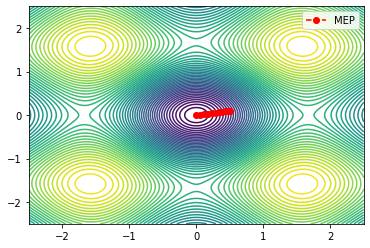

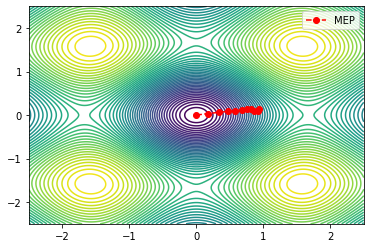

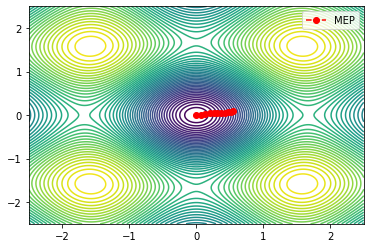

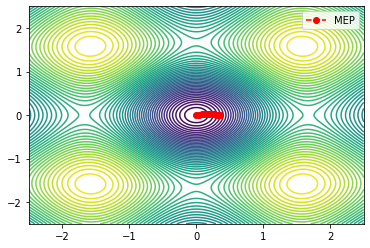

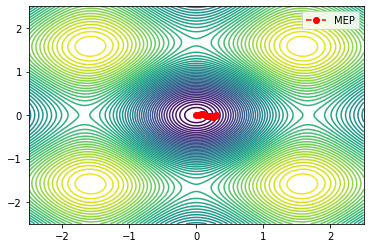

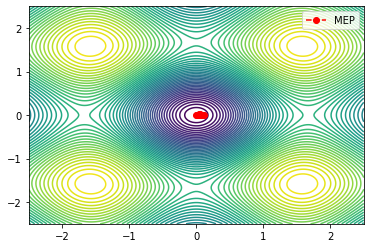

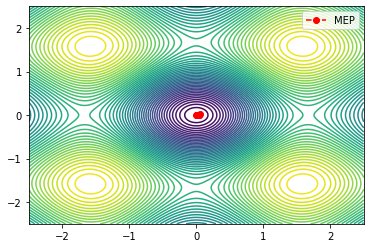

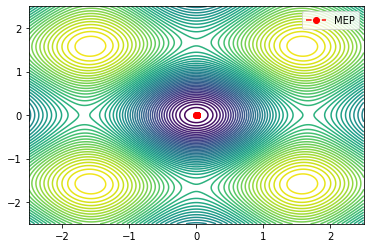

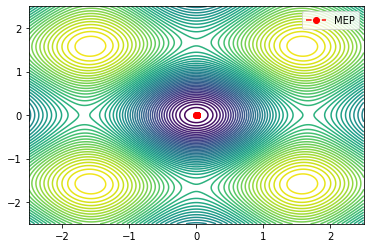

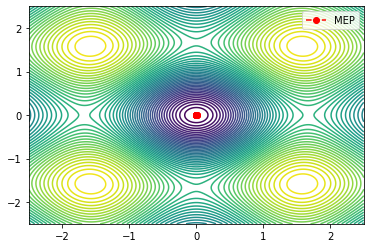

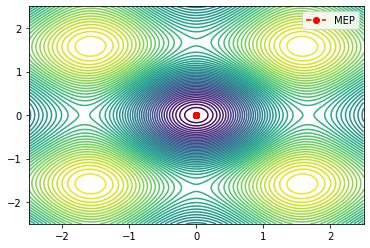

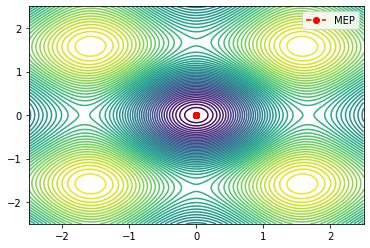

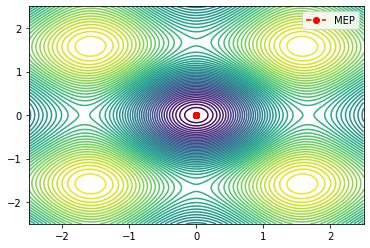

In [260]:
MAXITER=1500#max iteration steps
Phi=Init_stringA(a,b,N)
iter_error=[0]*(N+1)
start=time()
for step in range(MAXITER):
    print('Iteration %d'%step)
    Phi_new=np.zeros_like(Phi)#reset Phi_new
    #update string with projection method
    for i in range(0,N):#the other part of string,updated by projection step descent 
        difference=Phi[i]-Phi[i-1]
        tao=difference/LA.norm(difference)
#         rg=rungeKutta(Phi[i],dt,gradient_V)
        rg=rungeKutta(Phi[i],dt,lambda x:Proj_gradient_V(x,tao))
        Phi_new[i,:]=Phi[i,:]+rg#iteration scheme
        
    #the end, update by the climbing string method
    difference=Phi[-1]-Phi[-2]
    tao=difference/LA.norm(difference)
    rg=rungeKutta(Phi[-1],dt,lambda x:SD_Proj_gradient_V(x,tao))
    Phi_new[-1,:]=Phi[-1,:]+rg
    
        
    
    #Truncate the string
    
    #reparameterization
    T_Phi=Trunc(Phi_new)
    Phi=Repara(T_Phi,N)
#     Phi=Repara(Phi_new[:Truncate_string(Phi_new)+1],N)#update Phi
    iter_error=String_Error(Phi,Phi_new)
    print(max(iter_error))
    
    print('\n')
    
    if step%50==0:
        plt.figure()
        plt.plot(Phi[:,0],Phi[:,1],'--ro')
        plt.contour(X,Y,Z,50)
        # plt.plot(Init_string[:,0],Init_string[:,1],'b--o')
        plt.legend(['MEP','Initial'])
    if max(iter_error)<TOL:#if d<TOL stop iteration
        print('converges after %d steps'%step)
        break
    if step==MAXITER-1:
        print('does not converge until %d iteration'%MAXITER)
        break
    
time_cost=time()-start

Iteration 0
14.06476018931688


Iteration 1
2.578602131717882


Iteration 2
2.522935134789532


Iteration 3
2.4726042476633614


Iteration 4
2.4248898651031685


Iteration 5
2.3797374482179685


Iteration 6
2.337053826640237


Iteration 7
2.296721876879443


Iteration 8
2.258617283848548


Iteration 9
2.2226198817503446


Iteration 10
2.188620366186717


Iteration 11
2.156523360922371


Iteration 12
2.126247834899807


Iteration 13
2.0977257653611745


Iteration 14
2.0708997885952694


Iteration 15
2.0457204101211524


Iteration 16
2.0221431852450706


Iteration 17
2.000126141695256


Iteration 18
1.9796276034868747


Iteration 19
1.960604489419881


Iteration 20
1.9430110980553943


Iteration 21
1.9267983498152774


Iteration 22
1.9119134318526594


Iteration 23
1.898299778635032


Iteration 24
1.8858973173478077


Iteration 25
1.874642909439647


Iteration 26
1.864470925652446


Iteration 27
1.8553139000115633


Iteration 28
1.8471032172649406


Iteration 29
1.8397697972926914


Iter

1.0891812828951093


Iteration 265
1.0881360794712363


Iteration 266
1.0871009615110716


Iteration 267
1.0860758410016655


Iteration 268
1.0850606304350843


Iteration 269
1.0840552428135473


Iteration 270
1.08305959165473


Iteration 271
1.0820735909970411


Iteration 272
1.081097155403872


Iteration 273
1.080130199967844


Iteration 274
1.0791726403143875


Iteration 275
1.0782243926057453


Iteration 276
1.0772853735439945


Iteration 277
1.0763555003741843


Iteration 278
1.0754346908864774


Iteration 279
1.0745228634192638


Iteration 280
1.0736199368610517


Iteration 281
1.0727258306521505


Iteration 282
1.0718404647868054


Iteration 283
1.0709637598142505


Iteration 284
1.0700956368404981


Iteration 285
1.0692360175284557


Iteration 286
1.068384824100063


Iteration 287
1.0675419793355958


Iteration 288
1.0667074065755542


Iteration 289
1.0658810297190981


Iteration 290
1.0650627732266438


Iteration 291
1.0642525621173966


Iteration 292
1.0634503219708205


Iter

Iteration 551
0.9903577646057757


Iteration 552
0.9903212788014601


Iteration 553
0.9902851627372941


Iteration 554
0.990249412669512


Iteration 555
0.9902140248919549


Iteration 556
0.9901789957360438


Iteration 557
0.9901443215701794


Iteration 558
0.990109998799564


Iteration 559
0.9900760238654845


Iteration 560
0.9900423932456406


Iteration 561
0.9900091034528516


Iteration 562
0.9899761510354366


Iteration 563
0.9899435325766512


Iteration 564
0.9899112446941907


Iteration 565
0.9898792840398475


Iteration 566
0.9898476472995047


Iteration 567
0.9898163311922739


Iteration 568
0.9897853324707468


Iteration 569
0.9897546479199992


Iteration 570
0.9897242743580725


Iteration 571
0.9896942086346153


Iteration 572
0.9896644476317203


Iteration 573
0.9896349882624318


Iteration 574
0.9896058274716772


Iteration 575
0.9895769622344607


Iteration 576
0.9895483895572766


Iteration 577
0.9895201064762394


Iteration 578
0.9894921100576924


Iteration 579
0.989464

0.9869680738041096


Iteration 831
0.9869659480598835


Iteration 832
0.9869638438674457


Iteration 833
0.9869617610082849


Iteration 834
0.9869596992661017


Iteration 835
0.9869576584268612


Iteration 836
0.9869556382786873


Iteration 837
0.986953638611621


Iteration 838
0.9869516592182185


Iteration 839
0.9869496998928677


Iteration 840
0.9869477604321122


Iteration 841
0.9869458406344525


Iteration 842
0.98694394030063


Iteration 843
0.9869420592334157


Iteration 844
0.9869401972372772


Iteration 845
0.9869383541189698


Iteration 846
0.9869365296871472


Iteration 847
0.9869347237522506


Iteration 848
0.986932936126832


Iteration 849
0.98693116662522


Iteration 850
0.9869294150636717


Iteration 851
0.9869276812602885


Iteration 852
0.9869259650350861


Iteration 853
0.9869242662098602


Iteration 854
0.986922584608064


Iteration 855
0.9869209200551926


Iteration 856
0.9869192723784774


Iteration 857
0.9869176414066616


Iteration 858
0.9869160269703721


Iterat

<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Iteration 1001
0.9867951117471688


Iteration 1002
0.9867947395804075


Iteration 1003
0.9867943711868821


Iteration 1004
0.9867940065282919


Iteration 1005
0.9867936455668975


Iteration 1006
0.9867932882650705


Iteration 1007
0.9867929345856608


Iteration 1008
0.9867925844922855


Iteration 1009
0.9867922379481809


Iteration 1010
0.9867918949175164


Iteration 1011
0.9867915553647775


Iteration 1012
0.9867912192545


Iteration 1013
0.9867908865520137


Iteration 1014
0.9867905572225864


Iteration 1015
0.9867902312320904


Iteration 1016
0.9867899085466166


Iteration 1017
0.9867895891328046


Iteration 1018
0.9867892729572734


Iteration 1019
0.9867889599873185


Iteration 1020
0.9867886501905078


Iteration 1021
0.9867883435345399


Iteration 1022
0.9867880399876214


Iteration 1023
0.9867877395181807


Iteration 1024
0.9867874420951193


Iteration 1025
0.9867871476874994


Iteration 1026
0.9867868562647397


Iteration 1027
0.9867865677965534


Iteration 1028
0.98678628225308

<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()





Iteration 1140
0.9867673080641863


Iteration 1141
0.9867672177865258


Iteration 1142
0.9867671284240151


Iteration 1143
0.9867670399676487


Iteration 1144
0.9867669524080775


Iteration 1145
0.9867668657360665


Iteration 1146
0.9867667799429112


Iteration 1147
0.9867666950196031


Iteration 1148
0.9867666109572336


Iteration 1149
0.9867665277471486


Iteration 1150
0.9867664453806793


Iteration 1151
0.986766363849327


Iteration 1152
0.9867662831445835


Iteration 1153
0.9867662032580506


Iteration 1154
0.9867661241814324


Iteration 1155
0.9867660459065607


Iteration 1156
0.9867659684253035


Iteration 1157
0.9867658917295631


Iteration 1158
0.9867658158114258


Iteration 1159
0.9867657406629473


Iteration 1160
0.9867656662764204


Iteration 1161
0.9867655926440088


Iteration 1162
0.9867655197581877


Iteration 1163
0.9867654476112924


Iteration 1164
0.9867653761958145


Iteration 1165
0.9867653055044716


Iteration 1166
0.9867652355297722


Iteration 1167
0.986765166

<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Iteration 1251
0.9867612768532387


Iteration 1252
0.9867612477233093


Iteration 1253
0.9867612188887365


Iteration 1254
0.9867611903463349


Iteration 1255
0.9867611620934906


Iteration 1256
0.9867611341270205


Iteration 1257
0.9867611064440708


Iteration 1258
0.9867610790417743


Iteration 1259
0.9867610519174506


Iteration 1260
0.9867610250679183


Iteration 1261
0.9867609984906553


Iteration 1262
0.9867609721829429


Iteration 1263
0.986760946141878


Iteration 1264
0.9867609203648785


Iteration 1265
0.9867608948491513


Iteration 1266
0.9867608695921175


Iteration 1267
0.9867608445912714


Iteration 1268
0.986760819843788


Iteration 1269
0.9867607953471846


Iteration 1270
0.9867607710990978


Iteration 1271
0.9867607470967023


Iteration 1272
0.9867607233376708


Iteration 1273
0.9867606998195527


Iteration 1274
0.9867606765399696


Iteration 1275
0.9867606534962414


Iteration 1276
0.9867606306861959


Iteration 1277
0.9867606081074618


Iteration 1278
0.9867605857575

<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()





Iteration 1320
0.986759825988902


Iteration 1321
0.9867598115685182


Iteration 1322
0.9867597972944611


Iteration 1323
0.9867597831650508


Iteration 1324
0.9867597691788937


Iteration 1325
0.9867597553345857


Iteration 1326
0.9867597416306433


Iteration 1327
0.9867597280655962


Iteration 1328
0.9867597146381184


Iteration 1329
0.9867597013468357


Iteration 1330
0.9867596881900805


Iteration 1331
0.9867596751669429


Iteration 1332
0.9867596622757852


Iteration 1333
0.9867596495152361


Iteration 1334
0.9867596368841985


Iteration 1335
0.98675962438114


Iteration 1336
0.9867596120048332


Iteration 1337
0.986759599754019


Iteration 1338
0.9867595876274687


Iteration 1339
0.9867595756237623


Iteration 1340
0.9867595637418415


Iteration 1341
0.9867595519803157


Iteration 1342
0.9867595403381548


Iteration 1343
0.9867595288138792


Iteration 1344
0.9867595174064863


Iteration 1345
0.9867595061148747


Iteration 1346
0.9867594949375537


Iteration 1347
0.986759483873

<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-246-ba88db414d41>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()





Iteration 1446
0.9867587975552499


Iteration 1447
0.986758793561744


Iteration 1448
0.9867587896088076


Iteration 1449
0.9867587856959127


Iteration 1450
0.9867587818226375


Iteration 1451
0.9867587779886746


Iteration 1452
0.9867587741936493


Iteration 1453
0.9867587704370114


Iteration 1454
0.9867587667185103


Iteration 1455
0.9867587630376465


Iteration 1456
0.9867587593941837


Iteration 1457
0.9867587557875952


Iteration 1458
0.9867587522176292


Iteration 1459
0.9867587486838197


Iteration 1460
0.9867587451858321


Iteration 1461
0.9867587417233358


Iteration 1462
0.9867587382958809


Iteration 1463
0.9867587349032432


Iteration 1464
0.9867587315450495


Iteration 1465
0.9867587282207626


Iteration 1466
0.9867587249302923


Iteration 1467
0.9867587216731142


Iteration 1468
0.9867587184490185


Iteration 1469
0.9867587152575393


Iteration 1470
0.986758712098408


Iteration 1471
0.9867587089714355


Iteration 1472
0.9867587058760596


Iteration 1473
0.9867587028

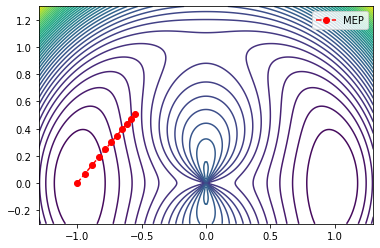

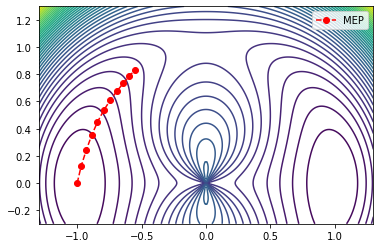

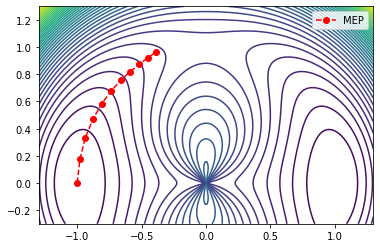

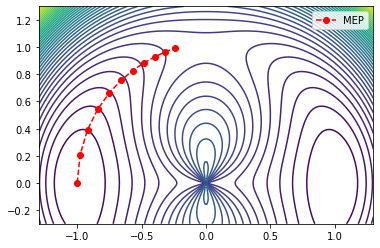

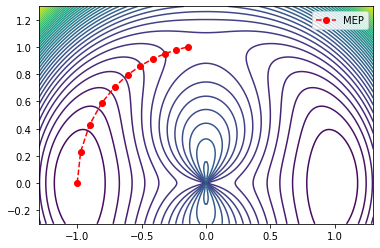

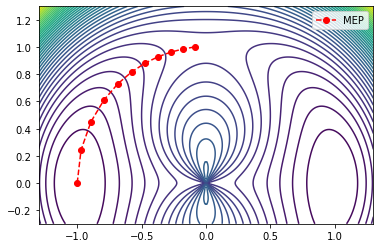

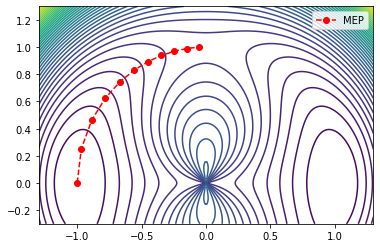

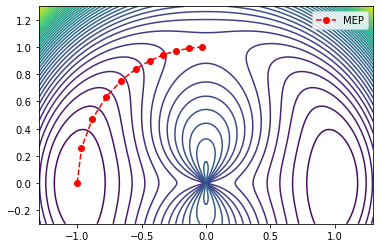

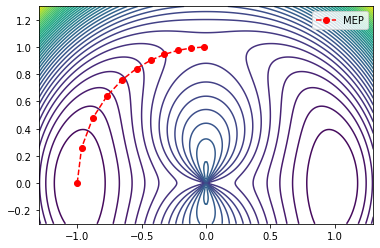

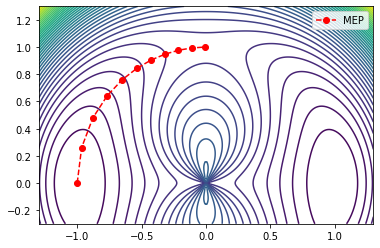

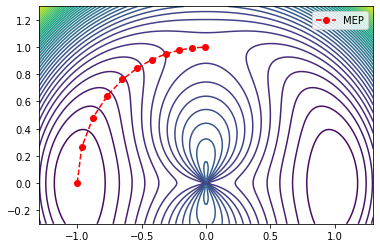

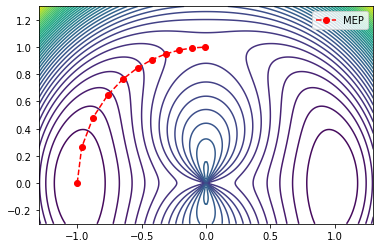

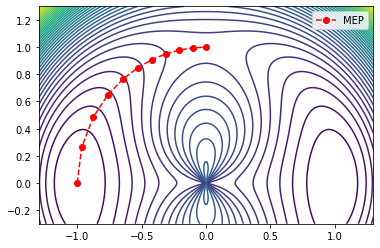

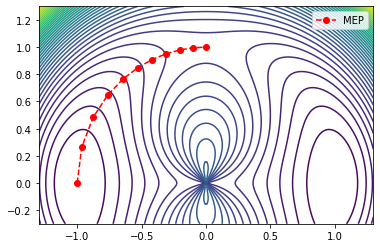

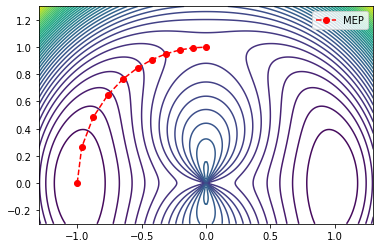

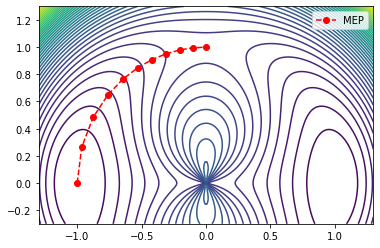

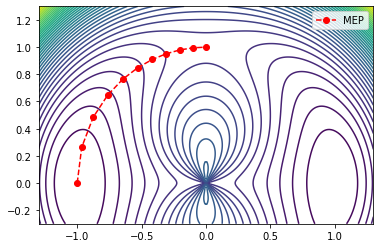

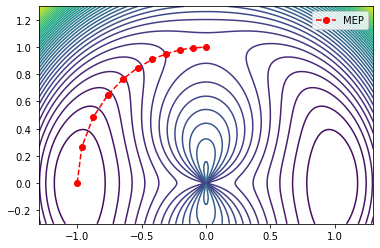

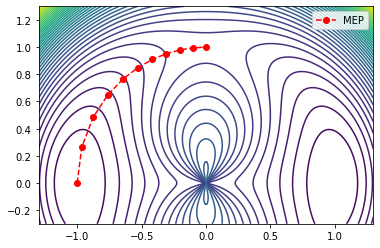

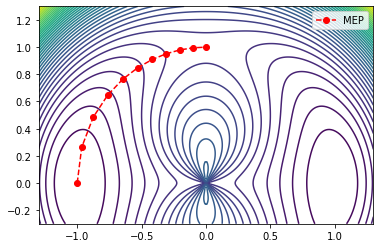

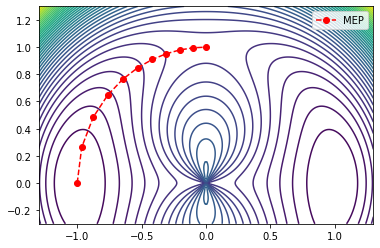

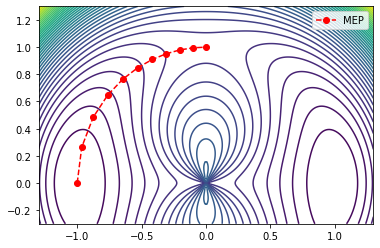

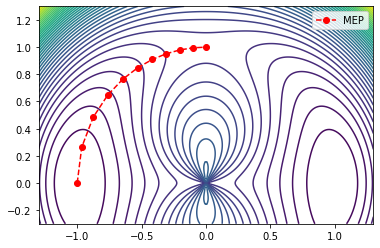

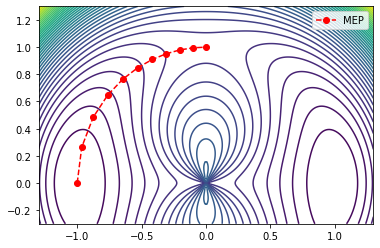

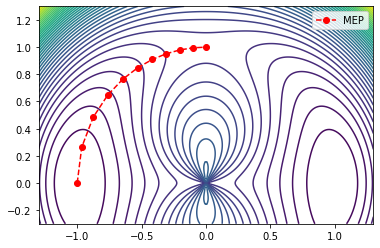

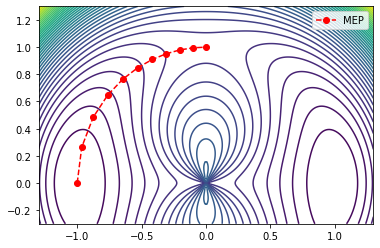

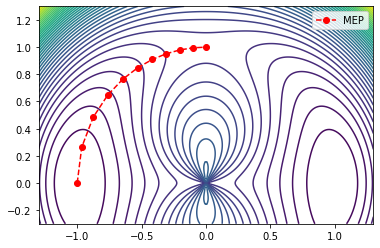

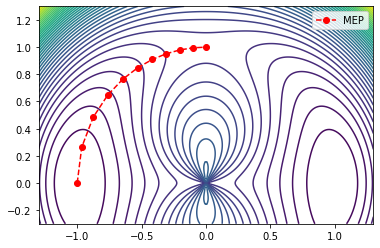

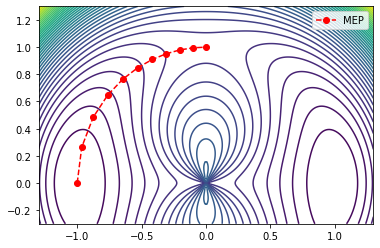

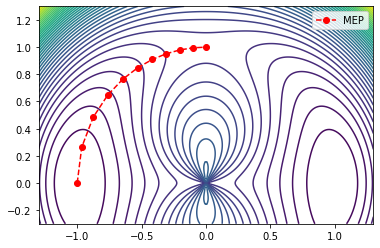

In [246]:
MAXITER=1500#max iteration steps
Phi=Init_stringA(a,b,N)
iter_error=[0]*(N+1)
start=time()
for step in range(MAXITER):
    print('Iteration %d'%step)
    Phi_new=np.zeros_like(Phi)#reset Phi_new
    #update string with projection method
    for i in range(0,N):#the other part of string,updated by projection step descent 
        difference=Phi[i]-Phi[i-1]
        tao=difference/LA.norm(difference)
        rg=rungeKutta(Phi[i],dt,gradient_V)
#         rg=rungeKutta(Phi[i],dt,lambda x:Proj_gradient_V(x,tao))
        Phi_new[i,:]=Phi[i,:]+rg#iteration scheme
        
    #the end, update by the climbing string method
    difference=Phi[-1]-Phi[-2]
    tao=difference/LA.norm(difference)
    rg=rungeKutta(Phi[-1],dt,lambda x:SD_Proj_gradient_V(x,tao))
    Phi_new[-1,:]=Phi[-1,:]+rg
    
        
    
    #Truncate the string
    
    #reparameterization
    T_Phi=Trunc(Phi_new)
    Phi=Repara(T_Phi,N)
#     Phi=Repara(Phi_new[:Truncate_string(Phi_new)+1],N)#update Phi
    iter_error=String_Error(Phi,Phi_new)
    print(max(iter_error))
    
    print('\n')
    
    if step%50==0:
        plt.figure()
        plt.plot(Phi[:,0],Phi[:,1],'--ro')
        plt.contour(X,Y,Z,50)
        # plt.plot(Init_string[:,0],Init_string[:,1],'b--o')
        plt.legend(['MEP','Initial'])
    if max(iter_error)<TOL:#if d<TOL stop iteration
        print('converges after %d steps'%step)
        break
    if step==MAXITER-1:
        print('does not converge until %d iteration'%MAXITER)
        break
    
time_cost=time()-start

In [247]:
gradient_V(Phi[-1])

array([5.00778773e-07, 6.86123357e-08])

In [248]:
s=[]
length=len(Phi)
s.append(0)#s_0=0
for i in range(length-1):
#     s.append(s[i]+np.exp(0.5*V(Phi[i+1,:])+0.5*V(Phi[i,:]))*LA.norm(Phi[i+1,:]-Phi[i,:]))
    s.append(s[i]+LA.norm(Phi[i+1,:]-Phi[i,:]))
alpha=np.array(s)/s[-1]

In [214]:
zfinal=list(map(V,Phi))

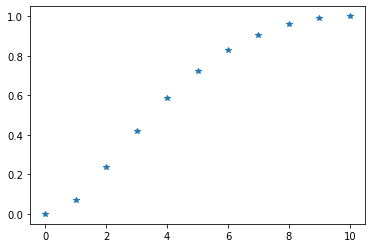

In [215]:
# plt.plot(zfinal1,"r*")
plt.plot(zfinal,'*')

In [216]:
# def Truncate_string(Phi):
#     zfinal=list(map(V,Phi))
#     maxid=0
#     length=len(zfinal)
#     for i in range(1,length-1):
#         if zfinal[i]>zfinal[i-1] and zfinal[i]>zfinal[i+1]:
#             maxid=i
#             break
#     return maxid

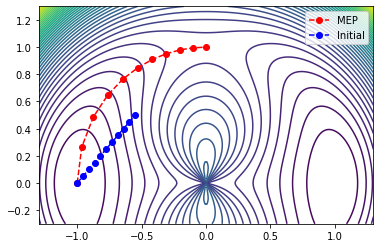

In [249]:
plt.plot(Phi[:,0],Phi[:,1],'--ro')
plt.contour(X,Y,Z,50)
plt.plot(Init_string[:,0],Init_string[:,1],'b--o')
plt.legend(['MEP','Initial'])

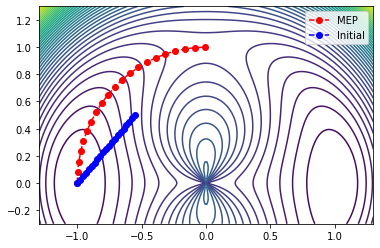

In [97]:
plt.plot(Phi[:,0],Phi[:,1],'--ro')
plt.contour(X,Y,Z,50)
plt.plot(Init_string[:,0],Init_string[:,1],'b--o')
plt.legend(['MEP','Initial'])

In [54]:
Truncate_string(Phi)

0

In [53]:
Phi,zfinal

(array([[-1.    ,  0.    ],
        [-0.9925,  0.04  ],
        [-0.985 ,  0.08  ],
        [-0.9775,  0.12  ],
        [-0.97  ,  0.16  ],
        [-0.9625,  0.2   ],
        [-0.955 ,  0.24  ],
        [-0.9475,  0.28  ],
        [-0.94  ,  0.32  ],
        [-0.9325,  0.36  ],
        [-0.925 ,  0.4   ],
        [-0.9175,  0.44  ],
        [-0.91  ,  0.48  ],
        [-0.9025,  0.52  ],
        [-0.895 ,  0.56  ],
        [-0.8875,  0.6   ],
        [-0.88  ,  0.64  ],
        [-0.8725,  0.68  ],
        [-0.865 ,  0.72  ],
        [-0.8575,  0.76  ],
        [-0.85  ,  0.8   ]]),
 [0.0,
  0.0017996944060255683,
  0.007099571221441831,
  0.015752429548961965,
  0.027609575400931213,
  0.042519000831301786,
  0.060327049545974606,
  0.08088353545865702,
  0.1040499553752536,
  0.12971015425603855,
  0.15778260216346157,
  0.18823335082626866,
  0.22108875921114787,
  0.2564471967031248,
  0.2944891205229476,
  0.3354851455636541,
  0.37980194594594613,
  0.427906021425293,
  0.4803655